In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns

In [314]:
'''
Purpose: This class represents a single module in the song bird system, aka HVC or RA
- can be though of a single layer, with a set of neurons that are designated as the input, and a set of neurons that are designated as the output, you can technically even set only to have input neurons if you want 
'''

class SpikingModule():
    def __init__(self, inter_neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant, initial_sparsity, initial_bias_range, reset_state, include_bias, state_noise):
        self.total_neurons = inter_neuron_count + input_count + output_count
        self.neuron_states = np.random.uniform(0, 1, (self.total_neurons))
        self.connectivity_matrix = np.random.uniform(-1, 1, (self.total_neurons, self.total_neurons))
        self.input_matrix = np.random.uniform(-1, 1, (input_count))
        self.inter_neuron_count = inter_neuron_count
        
        self.clock = 0
        self.state_noise = state_noise
        self.firing_history = []
        self.input_firing_history = []
        self.output_firing_history = []
        self.decay_rate = decay_rate
        self.learning_rate = learning_rate
        self.time_constant = time_constant
        self.threshold = threshold
        self.neuron_states_history = []
        self.reset_state = reset_state

        self.input_freeze_mask = np.zeros_like(self.input_matrix, dtype=bool)
        self.intra_freeze_mask = np.zeros((self.total_neurons, self.total_neurons), dtype=bool)
        
        self.input_count = input_count
        self.output_count = output_count
        
        self.initialize_bias(initial_bias_range, include_bias)
        self.last_spike_time = np.zeros(self.total_neurons, dtype=int)
        self.initialize_sparsity(initial_sparsity)

    def initialize_sparsity(self, initial_sparsity):
        for i in range(self.total_neurons):
            for j in range(self.total_neurons):
                if i == j or self.intra_freeze_mask[i, j]:
                    continue
                if np.random.uniform() > initial_sparsity:
                    self.connectivity_matrix[i, j] = 0

    def initialize_bias(self, initial_bias_range, include_bias):
        if include_bias:
            self.bias_matrix = np.random.uniform(-initial_bias_range, initial_bias_range, (self.total_neurons))
            self.input_bias_matrix = np.random.uniform(-initial_bias_range, initial_bias_range, (self.input_count))
        else:
            self.bias_matrix = np.zeros((self.total_neurons))
            self.input_bias_matrix = np.zeros((self.input_count))

    def stdp(self):
        # Update weights based on STDP rule
        for i in range(len(self.connectivity_matrix)):
            for j in range(len(self.connectivity_matrix[i])):
                if i == j or self.intra_freeze_mask[i, j]:
                    continue

                last_spike_i = self.last_spike_time[i]
                last_spike_j = self.last_spike_time[j]

                if last_spike_i is None or last_spike_j is None:
                    continue
                
                delta_t = last_spike_i - last_spike_j
                weight_update = self.learning_rate * self.stdp_rule(delta_t)
                self.connectivity_matrix[i, j] += weight_update

    def stdp_rule(self, delta_t):
        tau = self.time_constant
        if delta_t > 0:
            return np.exp(-delta_t / tau)
        else:
            return -np.exp(delta_t / tau)

    def step(self, input):
        # add the step noise
        self.neuron_states += np.random.normal(0, self.state_noise, self.neuron_states.shape)

        prev_state = self.neuron_states

        # process input
        weighted_input = np.multiply(self.input_matrix, input)
        weighted_input = np.add(weighted_input, self.input_bias_matrix)
        self.neuron_states[:len(input)] += weighted_input

        forward_updated = np.dot(prev_state, self.connectivity_matrix)

        forward_updated += self.bias_matrix

        updated_state = prev_state + forward_updated

        # multiply by the decay rate
        self.neuron_states = updated_state * self.decay_rate

        # find the neurons that have fired
        fired_neurons = np.where(self.neuron_states > self.threshold)
        # update the firing history
        self.firing_history.append(fired_neurons)

        # reset the neuron states of the fired neurons to 0
        self.neuron_states[fired_neurons] = self.reset_state

        # update last_spike_time for fired neurons
        self.last_spike_time[fired_neurons] = self.clock

        # compute the output spikes
        output_spikes_indices = np.where(self.neuron_states[-self.output_count:] > self.threshold)[0]
        output_spikes_indices += (self.total_neurons - self.output_count)

        # update the output firing history
        self.output_firing_history.append(output_spikes_indices)

        # update the weights
        self.stdp()

        self.neuron_states_history.append(np.copy(self.neuron_states))

        # increment the clock
        self.clock += 1

    def set_input_weights(self, input_weights):
        self.input_matrix = np.array(input_weights)

    def set_internal_weights(self, internal_weights):
        self.connectivity_matrix = np.array(internal_weights)

    def get_output(self):
        output = self.output_weights.T.dot(self.neuron_states)
        return output

    def get_internal_weights(self):
        return self.connectivity_matrix

    def set_input_weights(self, input_weights):
        self.input_matrix = input_weights

    def set_internal_states(self, internal_states):
        self.neuron_states = internal_states

    def set_internal_bias(self, bias):
        self.bias_matrix = bias

    def visualize_firing_history(self):
        # Create a figure for the firing history
        plt.figure(figsize=(10, 5))

        # Plot neuron firing history
        for i, fired_neurons in enumerate(self.firing_history):
            for neuron_idx in fired_neurons[0]:
                if neuron_idx < self.input_count:
                    color = 'gold'
                elif neuron_idx < self.input_count + self.inter_neuron_count:
                    color = 'skyblue'
                else:
                    color = 'limegreen'

                plt.plot(i, neuron_idx, marker='o', markersize=5, linestyle='None', color=color)

        plt.xlabel('Time Step')
        plt.ylabel('Neuron Index')
        plt.title('Firing History')

        # Set y-tick labels to integers
        y_ticks = np.arange(0, self.total_neurons, 1)
        plt.yticks(y_ticks)

        plt.show()

    def visualize_directed_graph(self):
        # Create a directed graph
        G = nx.DiGraph()

        # Add input, neuron, and output nodes
        input_nodes = range(self.input_count)
        inter_nodes = range(self.input_count, self.input_count + self.inter_neuron_count)
        output_nodes = range(self.input_count + self.inter_neuron_count, self.total_neurons)

        for node in input_nodes:
            G.add_node(node, node_type='input')
        for node in inter_nodes:
            G.add_node(node, node_type='inter')
        for node in output_nodes:
            G.add_node(node, node_type='output')

        # Add edges based on input, internal, and output connectivity matrices
        for i in range(self.total_neurons):
            for j in range(self.total_neurons):
                if i == j:
                    continue
                weight = self.connectivity_matrix[i, j]
                G.add_edge(i, j, weight=weight)

        # Position input nodes on the left, output nodes on the right, and inter-neuron nodes in between
        pos = {}
        for node in input_nodes:
            pos[node] = (0, (node / len(input_nodes)) * 2 - 1)
        for node in inter_nodes:
            pos[node] = (0.5, (node - len(input_nodes)) / len(inter_nodes) * 2 - 1)
        for node in output_nodes:
            pos[node] = (1, (node - self.input_count - self.inter_neuron_count) / len(output_nodes) * 2 - 1)

        # Plot the network
        fig, ax = plt.subplots()

        # Draw input, inter-neuron, and output nodes with different colors
        input_colors = ['gold'] * len(input_nodes)
        inter_colors = ['skyblue'] * len(inter_nodes)
        output_colors = ['limegreen'] * len(output_nodes)

        nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, node_size=1000, node_color=input_colors, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=inter_nodes, node_size=1000, node_color=inter_colors, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=output_nodes, node_size=1000, node_color=output_colors, ax=ax)

        # Draw edges with varying thickness based on weights and different colors for inhibitory and excitatory connections
        for (u, v, d) in G.edges(data=True):
            weight = d['weight']
            edge_color = "red" if weight < 0 else "black"
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=abs(weight) * 10, edge_color=edge_color, ax=ax)

        # Draw node labels
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax)

        plt.show()


    def freeze_weights(self, selected_neurons, percent_to_freeze, neurons=None):
        """
        Purpose:
        - Freeze the specified percentage of weights for the selected neurons or specific neurons.
        Args:
        - selected_neurons (str): 'input', 'intra', or 'output' to choose which weights to freeze.
        - percent_to_freeze (float): The percentage of weights to freeze (between 0 and 1).
        - neurons (list of int, optional): The indices of specific neurons to freeze. If not provided, weights are frozen randomly.
        """

        if selected_neurons not in ('input', 'intra', 'output'):
            raise ValueError("selected_neurons must be one of 'input', 'intra', or 'output'.")

        if not 0 <= percent_to_freeze <= 1:
            raise ValueError("percent_to_freeze must be between 0 and 1.")

        # Choose the weight matrix based on selected_neurons
        if selected_neurons == 'input':
            weight_matrix = self.input_matrix
        elif selected_neurons == 'intra':
            weight_matrix = self.internal_connectivity_matrix
        else:
            weight_matrix = self.output_weights

        # Create a mask to indicate frozen weights
        freeze_mask = np.zeros_like(weight_matrix, dtype=bool)

        if neurons is not None:
            if not all(isinstance(n, int) for n in neurons):
                raise ValueError("neurons must be a list of integers.")

            # Freeze all weights for the specified neurons
            for neuron_index in neurons:
                if selected_neurons == 'input':
                    freeze_mask[:, neuron_index] = True
                elif selected_neurons == 'intra':
                    freeze_mask[neuron_index, :] = True
                    freeze_mask[:, neuron_index] = True
                else:
                    freeze_mask[neuron_index, :] = True
        else:
            # Calculate the number of weights to freeze
            num_weights_to_freeze = int(np.prod(weight_matrix.shape) * percent_to_freeze)

            # Choose the indices of the weights to freeze
            freeze_indices = np.random.choice(np.arange(weight_matrix.size), num_weights_to_freeze, replace=False)
            freeze_mask.ravel()[freeze_indices] = True

        # Assign the freeze_mask to the corresponding attribute
        if selected_neurons == 'input':
            self.input_freeze_mask = freeze_mask
        elif selected_neurons == 'intra':
            self.intra_freeze_mask = freeze_mask
        else:
            self.output_freeze_mask = freeze_mask

    def visualize_neuron_state_history(self, neuron_indices):
        # Create a figure for the neuron state history
        plt.figure(figsize=(10, 5))

        for neuron_index in neuron_indices:
            # Check if neuron_index is within the range of total_neurons
            if neuron_index < 0 or neuron_index >= self.total_neurons:
                raise ValueError("neuron_index must be within the range of total_neurons.")

            neuron_state_history = []

            # Iterate through the neuron_states_history and extract the state of the specified neuron
            for neuron_states in self.neuron_states_history:
                neuron_state = neuron_states[neuron_index]
                neuron_state_history.append(neuron_state)

            # Plot neuron state history
            plt.plot(neuron_state_history, label=f'Neuron {neuron_index}')

            # Add a red dashed line when the neuron state reaches the threshold
            for i, neuron_states in enumerate(self.neuron_states_history):
                if neuron_states[neuron_index] >= self.threshold:
                    plt.axvline(i, linestyle='--', color='red', alpha=0.5)

        plt.xlabel('Time Step')
        plt.ylabel('Neuron State')
        plt.title('Neuron State History for Selected Neurons')
        plt.legend()

        plt.show()

    def visualize_internal_connectivity_matrix(self):
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        sns.heatmap(self.connectivity_matrix[:, :], annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title("Forward Connection Weights")

        plt.show()

    def remove_connection(self, selected_neurons, neuron_indices):
        """
        Purpose:
        - Set a certain weight to zero and freeze it permanently (remove the connection).
        Args:
        - selected_neurons (str): 'input', 'intra', or 'output' to choose which weights to remove.
        - neuron_indices (tuple): A tuple containing two indices (i, j) representing the weight to remove.
        """

        if selected_neurons not in ('input', 'intra', 'output'):
            raise ValueError("selected_neurons must be one of 'input', 'intra', or 'output'.")

        if not isinstance(neuron_indices, tuple) or len(neuron_indices) != 2 or not all(isinstance(n, int) for n in neuron_indices):
            raise ValueError("neuron_indices must be a tuple of two integers.")

        i, j = neuron_indices

        # Remove the connection and freeze the weight
        if selected_neurons == 'input':
            self.input_matrix[i, j] = 0
            self.input_freeze_mask[i, j] = True
        elif selected_neurons == 'intra':
            self.internal_connectivity_matrix[i, j] = 0
            self.intra_freeze_mask[i, j] = True
        else:
            self.output_weights[i, j] = 0
            self.output_freeze_mask[i, j] = True

    def no_input_step(self):
        """
        Purpose:
        - Perform a single time step of the network without any input.
        """
        self.step(np.zeros(self.input_matrix.shape[0]))

### Testing the SpikingModule Class

In [ ]:
input_count = 5
inter_neuron_count = 0
output_count = 4

decay_rate = .90
threshold = .5
learning_rate = 0.001
time_constant = 20
inital_sparsity = .5
initial_bias_range = 0
reset_state = .1
include_bias = False

# std of the noise to emulate spontatneous activity
state_noise = 0.15

module = SpikingModule(inter_neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant, inital_sparsity, initial_bias_range, reset_state=reset_state, state_noise=state_noise, include_bias=True)

module.set_input_weights(np.ones((input_count)))
module.set_internal_weights(np.zeros((input_count + inter_neuron_count + output_count, input_count + inter_neuron_count + output_count, 2)))
module.set_internal_states(np.zeros((input_count + inter_neuron_count + output_count)))

module.visualize_directed_graph()

for i in range(100):
    module.step(input=np.zeros((input_count)))

module.visualize_directed_graph()
module.visualize_firing_history()


### Testing the HVC Ability to Learn a Song Sequence

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
cycle: 5
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
cycle: 20
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
cycle: 35
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
cycle: 50
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0.

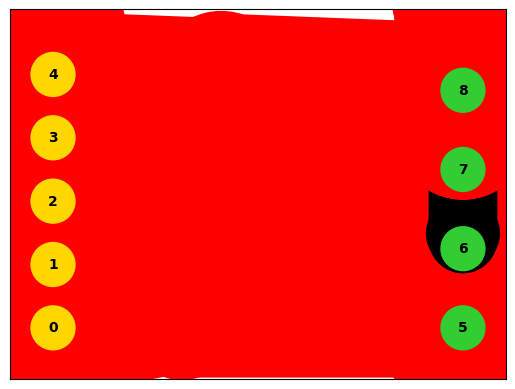

In [315]:
input_count = 5
inter_neuron_count = 0
output_count = 4

decay_rate = .8
threshold = .5
learning_rate = 0.001
time_constant = 20
inital_sparsity = .5
initial_bias_range = 0
reset_state = .1
include_bias = False
state_noise = 0.15

HVC = SpikingModule(inter_neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant, inital_sparsity, initial_bias_range, reset_state, include_bias=include_bias, state_noise=state_noise)

# steps between inputs from MMAN
between_syllables = 1
between_songs = 10

cycle_count = 10000
cycle = 0

# set input matrix all equal to one for now
HVC.set_input_weights(np.ones((input_count)))
HVC.set_internal_weights(np.zeros((input_count + inter_neuron_count + output_count, input_count + inter_neuron_count + output_count)))
# HVC.set_internal_states(np.ones((input_count + inter_neuron_count + output_count)))

while cycle < cycle_count:
    input = [2,0,0,0,0]
    HVC.step(input)
    for i in range(between_syllables):
        HVC.no_input_step()
    cycle+=between_syllables
    input = [0,2,0,0,0]
    HVC.step(input)
    for i in range(between_syllables):
        HVC.no_input_step()
    cycle+=between_syllables
    input = [0,0,2,0,0]
    HVC.step(input)
    for i in range(between_syllables):
        HVC.no_input_step()
    cycle+=between_syllables
    input = [0,0,0,2,0]
    HVC.step(input)
    for i in range(between_syllables):
        HVC.no_input_step()
    cycle+=between_syllables
    input = [0,0,0,0,2]
    HVC.step(input)
    for i in range(between_syllables):
        HVC.no_input_step()
    cycle+=between_syllables

    print(f"cycle: {cycle}")

    for i in range(between_songs):
        HVC.no_input_step()
    cycle += between_songs
    
HVC.visualize_directed_graph()
HVC.visualize_firing_history()
HVC.visualize_neuron_state_history([0,8])
HVC.visualize_internal_connectivity_matrix()

[0. 0.]
cycle: 3
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


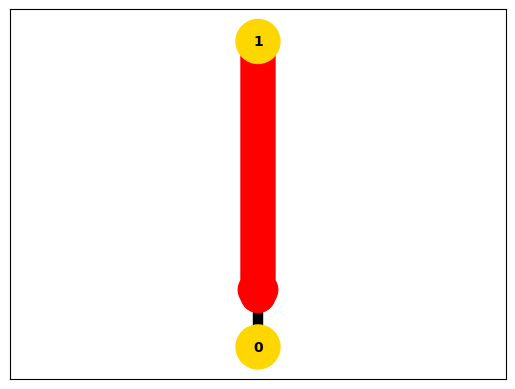

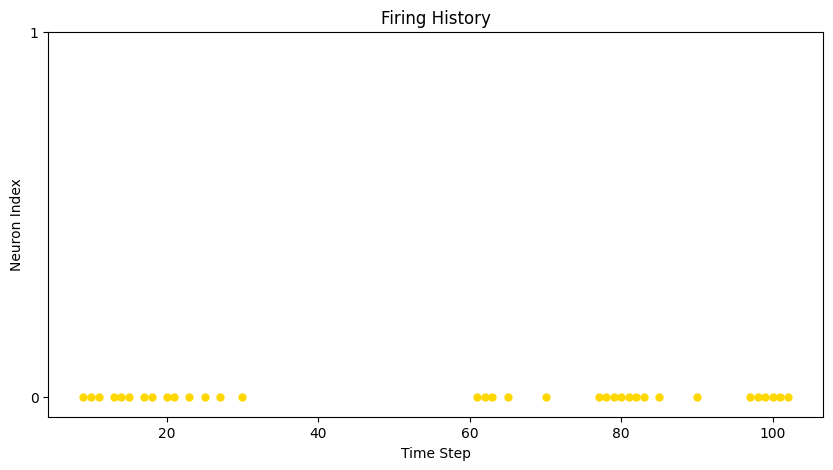

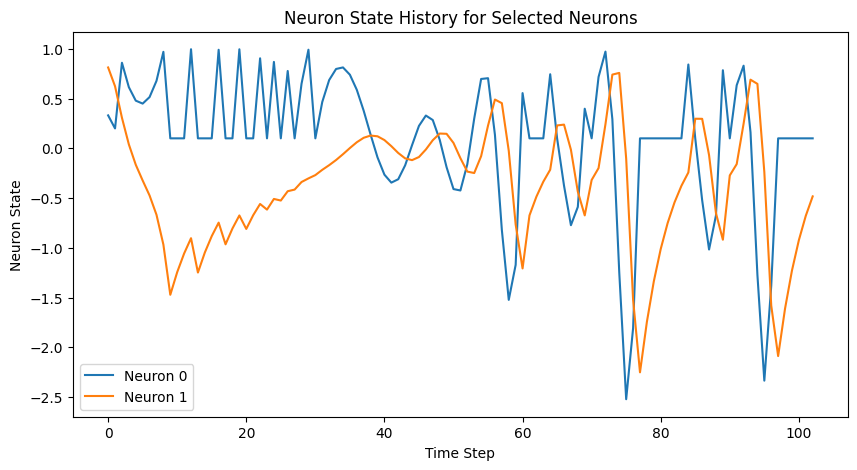

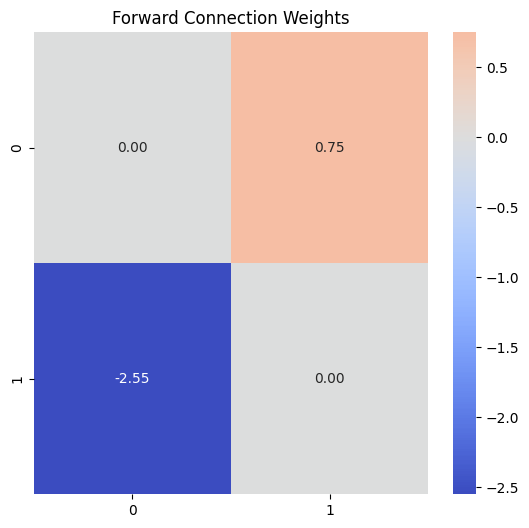

In [313]:
input_count = 2
inter_neuron_count = 0
output_count = 0

decay_rate = .8
threshold = 1
learning_rate = 0.1
time_constant = 20
inital_sparsity = .5
initial_bias_range = 0
reset_state = .1
include_bias = False
state_noise = 0

STDP_test = SpikingModule(inter_neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant, inital_sparsity, initial_bias_range, reset_state, include_bias=include_bias, state_noise=state_noise)

# steps between inputs from MMAN
between_syllables = 1

cycle_count = 100
cycle = 0

# set input matrix all equal to one for now
STDP_test.set_input_weights(np.ones((input_count)))
STDP_test.set_internal_weights(np.zeros((input_count + inter_neuron_count + output_count, input_count + inter_neuron_count + output_count)))
# HVC.set_internal_states(np.ones((input_count + inter_neuron_count + output_count)))

while cycle < cycle_count:
    STDP_test.step([0,1])
    cycle+=1
    STDP_test.no_input_step()
    cycle+=1
    STDP_test.step([1,0])
    cycle+=1
    print(f"cycle: {cycle}")
    for x in range(100):
        STDP_test.no_input_step()
        cycle+=1

STDP_test.visualize_directed_graph()
STDP_test.visualize_firing_history()
STDP_test.visualize_neuron_state_history([0,1])
STDP_test.visualize_internal_connectivity_matrix()
